For this practice I based the notebook in this reference: https://www.kaggle.com/raviolli77/random-forest-in-python.
This is a: Wisconsin Breast Cancer Machine Learning

**Abstract.**
For this project, I implemented a Random Forest Model on a data set containing descriptive attributes of digitized images of a process known as, fine needle aspirate (FNA) of breast mass.
We have a total of 29 features that were computed for each cell nucleus with an ID Number and the Diagnosis (Later converted to binary representations: Malignant = 1, Benign = 0).

**Origins**.
This data set originated in early 1990's, when Dr. William H. Wolberg was curious if he could find a way to accurately predict breast cancer diagnosis based on FNA's.

The research was broken down into two parts; the extraction of the data (which we will go over) and the classficattion (if you want to read more find information on this section here)

Origins
This data set originated in early 1990's, when Dr. William H. Wolberg was curious if he could find a way to accurately predict breast cancer diagnosis based on FNA's.

The research was broken down into two parts; the extraction of the data (which we will go over) and the classficattion (if you want to read more find information on this section here)

**Introduction to Random Forest**

Random forests, also known as random decision forests, are a popular ensemble method that can be used to build predictive models for both classification and regression problems. Ensemble methods use multiple learning models to gain better predictive results — in the case of a random forest, the model creates an entire forest of random uncorrelated decision trees to arrive at the best possible answer.

To demonstrate how this works in practice — specifically in a classification context — I’ll be walking you through an example using a famous data set from the University of California, Irvine (UCI) Machine Learning Repository. The data set, called the Breast Cancer Wisconsin (Diagnostic) Data Set, deals with binary classification and includes features computed from digitized images of biopsies.



**Decision Trees**
Decision trees are simple but intuitive models that utilize a top-down approach in which the root node creates binary splits until a certain criteria is met. This binary splitting of nodes provides a predicted value based on the interior nodes leading to the terminal (final) nodes. In a classification context, a decision tree will output a predicted target class for each terminal node produced.

Although intuitive, decision trees have limitations that prevent them from being useful in machine learning applications. 

**Bootstrap Aggregating Trees**
Through a process known as bootstrap aggregating (or bagging), it’s possible to create an ensemble (forest) of trees where multiple training sets are generated with replacement, meaning data instances — or in the case of this tutorial, patients — can be repeated. Once the training sets are created, a CART model can be trained on each subsample.

This approach helps reduce variance by averaging the ensemble's results, creating a majority-votes model. Another important feature of bagging trees is that the resulting model uses the entire feature space when considering node splits. Bagging trees allow the trees to grow without pruning, reducing the tree-depth sizes and resulting in high variance but lower bias, which can help improve predictive power.

However, a downside to this process is that the utilization of the entire feature space creates a risk of correlation between trees, increasing bias in the model.

**Limitations to Bagging Trees**
The main limitation of bagging trees is that it uses the entire feature space when creating splits in the trees. If some variables within the feature space are indicative of certain predictions, you run the risk of having a forest of correlated trees, thereby increasing bias and reducing variance.

However, a simple tweak of the bagging trees methodology can prove advantageous to the model’s predictive power.

**Random Forest**
Random forest aims to reduce the previously mentioned correlation issue by choosing only a subsample of the feature space at each split. Essentially, it aims to make the trees de-correlated and prune the trees by setting a stopping criteria for node splits, which I will cover in more detail later.

In [1]:
# Import modules
%matplotlib inline

import time
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier 
from urllib.request import urlopen 

plt.style.use('ggplot')
pd.set_option('display.max_columns', 500) 

**Load Data**
For this section, I'll load the data into a Pandas dataframe

In [2]:
breast_cancer = pd.read_csv('data.csv')


In [3]:
breast_cancer.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
breast_cancer.columns

Index(['id', 'diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'Unnamed: 32'],
      dtype='object')

In [5]:
names = ['id', 'diagnosis', 'radius_mean', 
         'texture_mean', 'perimeter_mean', 'area_mean', 
         'smoothness_mean', 'compactness_mean', 
         'concavity_mean','concave_points_mean', 
         'symmetry_mean', 'fractal_dimension_mean',
         'radius_se', 'texture_se', 'perimeter_se', 
         'area_se', 'smoothness_se', 'compactness_se', 
         'concavity_se', 'concave_points_se', 
         'symmetry_se', 'fractal_dimension_se', 
         'radius_worst', 'texture_worst', 
         'perimeter_worst', 'area_worst', 
         'smoothness_worst', 'compactness_worst', 
         'concavity_worst', 'concave_points_worst', 
         'symmetry_worst', 'fractal_dimension_worst'] 

dx = ['Benign', 'Malignant']

**Cleaning**
We do some minor cleanage like setting the id_number to be the data frame index, along with converting the diagnosis to the standard binary 1, 0 representation using the map() function.

In [6]:
# Setting 'id_number' as our index
breast_cancer.set_index(['id'], inplace = True) #Set the DataFrame index using existing columns.
#Set the DataFrame index (row labels) using one or more existing columns or arrays (of the correct length).
#The index can replace the existing index or expand on it.


# Converted to binary to help later on with models and plots
breast_cancer['diagnosis'] = breast_cancer['diagnosis'].map({'M':1, 'B':0})

In [7]:
breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


**Missing Values**
Given context of the data set, I know that there is no missing data, but I ran an apply method utilizing a lambda expression that checks to see if there was any missing values through each column. Printing the column name and total missing values for that column, iteratively.

In [8]:
breast_cancer.apply(lambda x: x.isnull().sum())

diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed: 32                569
dtype: i

We have to delete this extra column since it doesn't contain any data.

This following code will be used for the random forest model, where the id_number won't be relevant.

In [9]:
# For later use in CART models
names_index = names[2:]

In [10]:
print(names_index)

['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean', 'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se', 'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst']


Here we're deleting the extra column

In [11]:
del breast_cancer['Unnamed: 32']

Next, we'll give the dimensions of the data set; where the first value is the number of patients and the second value is the number of features.

We print the data types of our data set this is important because this will often be an indicator of missing data, as well as giving us context to anymore data cleanage.

In [12]:
print("Here's the dimensions of our data frame:\n", 
     breast_cancer.shape)
print("Here's the data types of our columns:\n",
     breast_cancer.dtypes)

Here's the dimensions of our data frame:
 (569, 31)
Here's the data types of our columns:
 diagnosis                    int64
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64

Class Imbalance
The distribution of diagnoses is important because it speaks to class imbalance within machine learning and data mining applications. Class imbalance is a term used to describe when a target class within a data set is outnumbered by another target class (or classes). This can create misleading accuracy metrics, known as an accuracy paradox. To make sure our target classes aren't imbalanced, create a function that will output the distribution of the target classes.

Note: If your data set suffers from class imbalance, I suggest reading up on upsampling and downsampling.

In [13]:
def print_dx_perc(data_frame, col):
    """Function used to print class distribution for our data set"""
    try:
        # Stores value counts
        col_vals = data_frame[col].value_counts()
        # Resets index to make index a column in data frame
        col_vals = col_vals.reset_index()
        # If the number of unique instances in column exceeds 20 print warning
        if len(col_vals['index']) > 20:
            print('Warning: values in column are more than 20 \nPlease try a column with lower value counts!')
        # Else it calculates/prints percentage for each unique value in column
        else:
            # Create a function to output the percentage
            f = lambda x, y: 100 * (x / sum(y))
            for i in range(0, len(col_vals['index'])):
                print('{0} accounts for {1:.2f}% of the {2} column'\
                      .format(col_vals['index'][i],
                              f(col_vals[col].iloc[i],
                                col_vals[col]),
                              col))
    # try-except block goes here if it can't find the column in data frame
    except KeyError as e:
        print('{0}: Not found'.format(e))
        print('Please choose the right column name!')

In [14]:
print_dx_perc(breast_cancer, 'diagnosis')

0 accounts for 62.74% of the diagnosis column
1 accounts for 37.26% of the diagnosis column


Fortunately, this data set does not suffer from class imbalance.

Next, we will employ a function that gives us standard descriptive statistics for each feature including mean, standard deviation, minimum value, maximum value, and range intervals.

In [15]:
breast_cancer.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


You can see in the maximum row of the chart that our data varies in distribution; this will be important as we consider classification models. Standardization is an important requirement for many classification models that should be handled when implementing pre-processing. Some models (like neural networks) can perform poorly if pre-processing isn't considered, so the describe() function is a good indicator for standardization. Fortunately, random forest does not require any pre-processing. (For use of categorical data, see sklearn's Encoding Categorical Data section).

**Creating Training and Test Sets**
Let's split the data set into our training and test sets, which will be pseudo-randomly selected to create a 80-20% split. You will use the training set to train the model and perform some optimization. You will use the test set, which will act as unseen data, to assess model performance.

When using this method for machine learning, always be wary of utilizing your test set to create models.

In [16]:
X = breast_cancer.iloc[:, breast_cancer.columns != 'diagnosis']
y = breast_cancer.iloc[:, breast_cancer.columns == 'diagnosis']


training_set, test_set, class_set, test_class_set = train_test_split(X,
                                                                    y,
                                                                    test_size = 0.20, 
                                                                    random_state = 42)

In [17]:
print(class_set)
print(test_class_set)

          diagnosis
id                 
859471            0
873593            1
859196            0
88466802          0
858970            0
...             ...
859711            0
863031            0
8910721           0
908489            1
862965            0

[455 rows x 1 columns]
          diagnosis
id                 
87930             0
859575            1
8670              1
907915            0
921385            0
...             ...
913102            0
8610404           1
884689            0
883270            0
88995002          1

[114 rows x 1 columns]


In [18]:
# Cleaning test sets to avoid future warning messages
class_set = class_set.values.ravel() 
test_class_set = test_class_set.values.ravel() 

In [19]:
print(class_set)
print(test_class_set)

[0 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 1 0 0 1 0 1 1 1 0 1
 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0
 1 0 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 1 0
 0 1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 1 0 1 0 1
 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 1 0
 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 1 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1
 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1
 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0
 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 1
 0 0 1 1 1 0 0 0 1 1 0 1 1 0 0 0 1 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 0 0
 0 0 0 1 1 1 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0
 0 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 1
 0 1 1 0 1 0 0 0 0 1 0]
[0 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 

**Fitting Random Forest**
Now, let's create the model, starting with parameter tuning. Here are the parameters we will be tuning in this tutorial:

max_depth: The maximum splits for all trees in the forest. bootstrap: An indicator of whether or not we want to use bootstrap samples when building trees.
max_features: The maximum number of features that will be used in node splitting — the main difference I previously mentioned between bagging trees and random forest. Typically, you want a value that is less than p, where p is all features in your data set.
criterion: This is the metric used to asses the stopping criteria for the decision trees.
Once we've instantiated our model, we will go ahead and tune our parameters.

In [20]:
from sklearn.ensemble import RandomForestClassifier
# Set the random state for reproducibility
fit_rf = RandomForestClassifier(random_state=42)

Hyperparameters Optimization
Utilizing the GridSearchCV functionality, let's create a dictionary with parameters we are looking to optimize to create the best model for our data. Setting the n_jobs to 3 tells the grid search to run three jobs in parallel, reducing the time the function will take to compute the best parameters. I included the timer to see how long different jobs took; that led me to ultimately decide to use three parallel jobs.

This will help set the parameters we will use to tune one final parameter: the number of trees in our forest.

In [22]:
np.random.seed(42)
start = time.time()

param_dist = {'max_depth': [2, 3, 4],    #The maximum depth of the tree. 
              'bootstrap': [True, False], #
              'max_features': ['auto', 'sqrt', 'log2', None],
               #max_features:The number of features to consider when looking for the best split
              'criterion': ['gini', 'entropy']}#The function to measure the quality of a split.

cv_rf = GridSearchCV(fit_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = -1)

cv_rf.fit(training_set, class_set)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2'}
Time taken in grid search:  32.75


Once we are given the best parameter combination, we set the parameters to our model.

Notice how we didn't utilize the bootstrap: True parameter, this will make sense in the following section.

In [23]:
# Set best parameters given by grid search 
fit_rf.set_params(criterion = 'entropy',
                  max_features = 'log2', 
                  max_depth = 4)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [24]:
fit_rf.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 15
max_estimators = 1000

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    fit_rf.set_params(n_estimators=i)
    fit_rf.fit(training_set, class_set)

    oob_error = 1 - fit_rf.oob_score_
    error_rate[i] = oob_error

In [25]:
# Convert dictionary to a pandas series for easy plotting 
oob_series = pd.Series(error_rate)

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

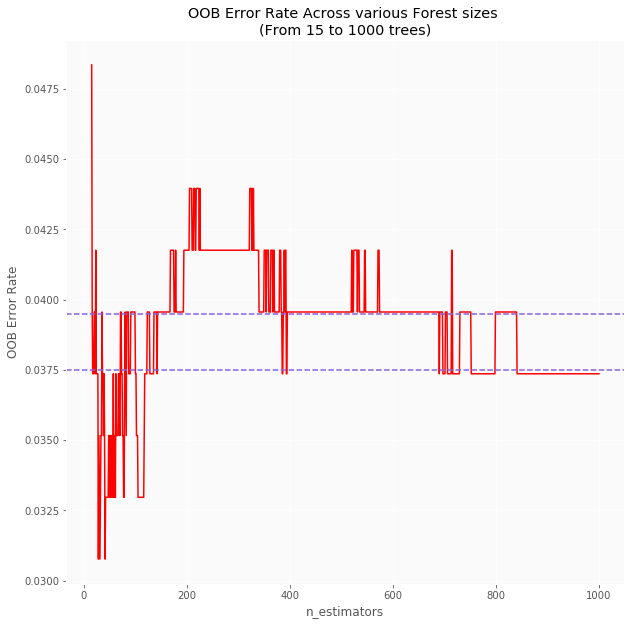

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',
                color = 'red')
plt.axhline(0.0395, 
            color='#875FDB',
           linestyle='--')
plt.axhline(0.0375, 
            color='#875FDB',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 15 to 1000 trees)')

The OOB error rate starts to oscilate at around 400 trees, so I will go ahead and use my judgement to use 400 trees in my forest. Using the pandas series object I can easily find the OOB error rate for the estimator as follows:

In [33]:
print('OOB Error rate for 400 trees is: {0:.5f}'.format(oob_series[400]))

OOB Error rate for 400 trees is: 0.03956


Utilizing the OOB error rate that was created with the model gives us an unbiased error rate. Since OOB can be calculated with the model estimation, it's helpful when cross validating and/or optimizing hyperparameters prove to be too computationally expensive.

For the sake of this tutorial, I will go over other traditional methods for optimizing machine learning models, including the training and test error route and cross validation metrics.

**Traditional Training and Test Set Split**
In order for this methodology to work we will set the number of trees calculated using the OOB error rate, and removing the warm_start and oob_score parameters. Along with including the bootstrap parameter.

In [34]:
fit_rf.set_params(n_estimators=400,
                  bootstrap = True,
                  warm_start=False, 
                  oob_score=False)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Training Algorithm**
Next we train the algorithm utilizing the training and target class set we had made earlier.

In [35]:
fit_rf.fit(training_set, class_set)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=4, max_features='log2',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=400,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

**Variable Importance**
Once we have trained the model, we can assess variable importance. One downside to using ensemble methods with decision trees is that you lose the interpretability a single tree gives. A single tree can outline for us important node splits, as well as variables that were important at each split.

Fortunately, ensemble methods that rely on CART models use a metric to evaluate the homogeneity of splits. Thus, when creating ensembles, these metrics can be utilized to give insight into the important variables used in the training of the model. Two such metrics are gini impurity and entropy. Many people favor gini impurity because it has a lower computational cost than entropy, which requires calculating the logarithmic function. For more information, I recommend reading this article.

The two metrics vary and from reading documentation online, many people favor gini impurity due to the computational cost of entropy since it requires calculating the logarithmic function. For more discussion I recommend reading this article.

Here we define each metric:

Gini Impurity=1−∑ipi
 
and

Entropy=∑i−pi∗log2pi
 
where  pi  is defined as the proportion of subsamples that belong to a certain target class.

Since we are utilizing the gini impurity, the impurity measure reaches 0 when all target class labels are the same.

Let's access the feature importance of the model and use a helper function to output the importance of our variables in descending order.

In [36]:
def variable_importance(fit):
    """
    Purpose
    ----------
    Checks if model is fitted CART model then produces variable importance
    and respective indices in dictionary.

    Parameters
    ----------
    * fit:  Fitted model containing the attribute feature_importances_

    Returns
    ----------
    Dictionary containing arrays with importance score and index of columns
    ordered in descending order of importance.
    """
    try:
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Captures whether the model has been trained
        if not vars(fit)["estimators_"]:
            return print("Model does not appear to be trained.")
    except KeyError:
        print("Model entered does not contain 'estimators_' attribute.")

    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [37]:
var_imp_rf = variable_importance(fit_rf)

importances_rf = var_imp_rf['importance']

indices_rf = var_imp_rf['index']

In [38]:
def print_var_importance(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on information gain for CART model.
    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
                based on feature_importances_
    * name_index: Name of columns included in model

    Returns
    ----------
    Prints feature importance in descending order
    """
    print("Feature ranking:")

    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1,
                      names_index[indices[i]],
                      importance[indices[f]]))

In [39]:
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'area_worst' has a Mean Decrease in Impurity of 0.12603
2. The feature 'perimeter_worst' has a Mean Decrease in Impurity of 0.11260
3. The feature 'concave_points_worst' has a Mean Decrease in Impurity of 0.11156
4. The feature 'concave_points_mean' has a Mean Decrease in Impurity of 0.09233
5. The feature 'radius_worst' has a Mean Decrease in Impurity of 0.07561
6. The feature 'concavity_mean' has a Mean Decrease in Impurity of 0.05808
7. The feature 'area_mean' has a Mean Decrease in Impurity of 0.04866
8. The feature 'concavity_worst' has a Mean Decrease in Impurity of 0.04826
9. The feature 'radius_mean' has a Mean Decrease in Impurity of 0.04690
10. The feature 'perimeter_mean' has a Mean Decrease in Impurity of 0.04466
11. The feature 'area_se' has a Mean Decrease in Impurity of 0.04033
12. The feature 'texture_worst' has a Mean Decrease in Impurity of 0.02461
13. The feature 'compactness_worst' has a Mean Decrease in Impurity of 0.01990
14. The fe

We can see here that our top 5 variables were area_worst, perimeter_worst, concave_points_worst, concave_points_mean, radius_worst.

This gives us great insight for further analyses like feature engineering, although I won't get into that topic during this tutorial. It can also give us insight into the mind of the practitioner by showing what variables played an important part in the predictions generated by the model. In the case of our test data set, knowing this information would help practitioners in the medical field focus on the top variables and their relationship with breast cancer.

In [44]:
def variable_importance_plot(importance, indices, name_index):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.

    Parameters
    ----------
    * importance: Array returned from feature_importances_ for CART
                models organized by dataframe index
    * indices: Organized index of dataframe from largest to smallest
                based on feature_importances_
    * name_index: Name of columns included in model

    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(indices.shape[0] - 1, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_facecolor('#fafafa')
    plt.title('Feature importances for Random Forest Model\
    \nBreast Cancer (Diagnostic)')
    plt.barh(index,
             importance_desc,
             align="center",
             color = '#875FDB')
    plt.yticks(index,
               feature_space)

    plt.ylim(-1, 30)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Impurity')
    plt.ylabel('Feature')

    plt.show()
    plt.close()

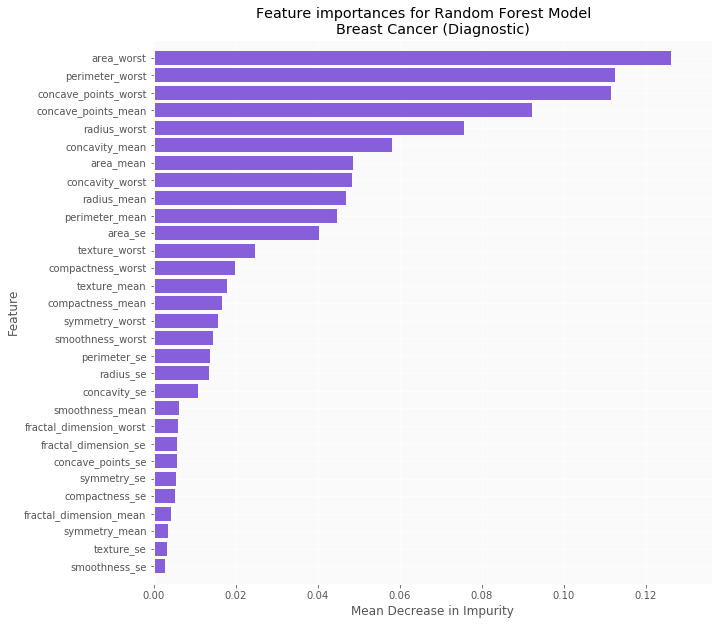

In [45]:
variable_importance_plot(importances_rf, indices_rf, names_index)

**Cross Validation**
Cross validation is a powerful tool that is used for estimating the predictive power of your model, and it performs better than the conventional training and test set. Using cross validation, we can create multiple training and test sets and average the scores to give us a less biased metric.

In this case, we will create 10 sets within our data set that calculate the estimations we have done already, then average the prediction error to give us a more accurate representation of our model's prediction power. The model's performance can vary significantly when utilizing different training and test sets.

**K-Fold Cross Validation**
Here we are employing K-fold cross validation; more specifically, 10 folds. We are creating 10 subsets of our data on which to employ the training and test set methodology; then we will average the accuracy for all folds to give us our estimation.

Within a random forest context, if your data set is significantly large, you can choose to not do cross validation and instead use the OOB error rate as an unbiased metric for computational costs. But for the purposes of this tutorial, I included it to show the different accuracy metrics available.

In [46]:
def cross_val_metrics(fit, training_set, class_set, estimator, print_results = True):
    """
    Purpose
    ----------
    Function helps automate cross validation processes while including 
    option to print metrics or store in variable

    Parameters
    ----------
    fit: Fitted model 
    training_set:  Data_frame containing 80% of original dataframe
    class_set:     data_frame containing the respective target vaues 
                      for the training_set
    print_results: Boolean, if true prints the metrics, else saves metrics as 
                      variables

    Returns
    ----------
    scores.mean(): Float representing cross validation score
    scores.std() / 2: Float representing the standard error (derived
                from cross validation score's standard deviation)
    """
    my_estimators = {
    'rf': 'estimators_',
    'nn': 'out_activation_',
    'knn': '_fit_method'
    }
    try:
        # Captures whether first parameter is a model
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        # Captures whether the model has been trained
        if not vars(fit)[my_estimators[estimator]]:
            return print("Model does not appear to be trained.")

    except KeyError as e:
        print("'{0}' does not correspond with the appropriate key inside the estimators dictionary. \
\nPlease refer to function to check `my_estimators` dictionary.".format(estimator))
        raise

    n = KFold(n_splits=10)
    scores = cross_val_score(fit, 
                         training_set, 
                         class_set, 
                         cv = n)
    if print_results:
        for i in range(0, len(scores)):
            print("Cross validation run {0}: {1: 0.3f}".format(i, scores[i]))
        print("Accuracy: {0: 0.3f} (+/- {1: 0.3f})"\
              .format(scores.mean(), scores.std() / 2))
    else:
        return scores.mean(), scores.std() / 2

In [47]:
cross_val_metrics(fit_rf, 
                  training_set, 
                  class_set, 
                  'rf',
                  print_results = True)

Cross validation run 0:  1.000
Cross validation run 1:  0.957
Cross validation run 2:  0.935
Cross validation run 3:  0.935
Cross validation run 4:  0.957
Cross validation run 5:  0.978
Cross validation run 6:  0.978
Cross validation run 7:  0.933
Cross validation run 8:  1.000
Cross validation run 9:  0.933
Accuracy:  0.960 (+/-  0.013)


**Test Set Metrics**
Using the test set that was created earlier, let's examine another metric for the evaluation of our model. You'll recall that that we didn't touch the test set until now — after we had completed hyperparamter optimization — to avoid the problem of data leakage.

Here, I have created a confusion matrix showcasing the following metrics:

Test Set Metrics
Using the test set that was created earlier, let's examine another metric for the evaluation of our model. You'll recall that that we didn't touch the test set until now — after we had completed hyperparamter optimization — to avoid the problem of data leakage.

Here, I have created a confusion matrix showcasing the following metrics:

n = Sample Size	Predicted Benign	Predicted Malignant
Actual Benign	True Negative	False Positive
Actual Malignant	False Negative	True Positive

In [49]:
predictions_rf = fit_rf.predict(test_set)

Confusion Matrix
Here we create a confusion matrix visual with seaborn and transposing the matrix when creating the heatmap.

In [50]:
def create_conf_mat(test_class_set, predictions):
    """Function returns confusion matrix comparing two arrays"""
    if (len(test_class_set.shape) != len(predictions.shape) == 1):
        return print('Arrays entered are not 1-D.\nPlease enter the correctly sized sets.')
    elif (test_class_set.shape != predictions.shape):
        return print('Number of values inside the Arrays are not equal to each other.\nPlease make sure the array has the same number of instances.')
    else:
        # Set Metrics
        test_crosstb_comp = pd.crosstab(index = test_class_set,
                                        columns = predictions)
        # Changed for Future deprecation of as_matrix
        test_crosstb = test_crosstb_comp.values
        return test_crosstb

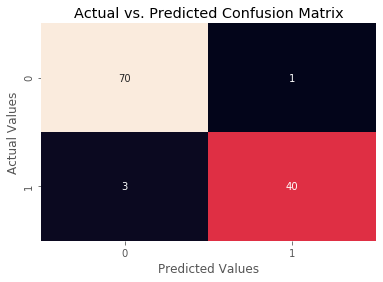

In [51]:
conf_mat = create_conf_mat(test_class_set, predictions_rf)
sns.heatmap(conf_mat, annot=True, fmt='d', cbar=False)
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Actual vs. Predicted Confusion Matrix')
plt.show()

In [53]:
accuracy_rf = fit_rf.score(test_set, test_class_set)
print("Here is our mean accuracy on the test set:\n {0:.3f}"\
      .format(accuracy_rf))

Here is our mean accuracy on the test set:
 0.965


In [54]:
# Here we calculate the test error rate!
test_error_rate_rf = 1 - accuracy_rf
print("The test error rate for our model is:\n {0: .4f}"\
      .format(test_error_rate_rf))

The test error rate for our model is:
  0.0351


As you can see we got a very similar error rate for our test set that we did for our OOB, which is a good sign for our model.